In [1]:
from Functions import *
import winsound

In [2]:
''' Beam parameters '''
N = 1024			# number of sampling points
E0 = 9481			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 50000		# total simulation time window [fs]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 650-26
}

In [3]:
##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'optimization/'; make_dir(dir_case)

print('\nCWD:',dir_case)

path exists
path exists
path exists

CWD: output/9481eV/optimization/


In [4]:
def define_beamline(
    E0, m1_p=185.0, m2_p=175.5,
    HHLM_type='2DCM', HHLM_distance_factor=1.0,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 9.0,
    hkl2 = [1,1,1], alphaAsym2 = 0.0,
    hkl3 = [4,4,0], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=256)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m2_p=m2_p)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0, HHLM_distance_factor=HHLM_distance_factor,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0, HHLM_distance_factor=HHLM_distance_factor,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)
    
    all_devices = [im_input] + Telescope_devices + HHLM_devices + HRM_devices
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline


### Setup beamline and calculate beam profiles at each optics to determine the crystal profiles

In [5]:
##### perfect case
m1_p = 185.0; m2_p = 175.5
slit_width = 1e-1
f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = '2DCM'              # 2DCM or Zigzag
HHLM_distance_factor = 1.0      # how far apart do we scale the HHLM crystals
hkl1 = [1,1,1]; alphaAsym1 = 9.0    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [4,4,0]; alphaAsym2 = 5.5    # ````````````````````````2nd pair of HHLM crystal
hkl3 = [4,4,0]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices, mono_beamline = define_beamline(E0,
                               m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                               HHLM_distance_factor = HHLM_distance_factor,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)


b 0.15
b 6.76
b 0.15
b 6.76
b 1.00
b 1.81
slit width: 100000.0 um
b 0.55
b 1.00


In [6]:
%%capture capt
# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)
crystal_powers = [2.26, 33.98, 0.44, 0.42, 5.07, 0.867]

b1 = beam.Beam(beam_params=beam_params)
b2 = mono_beamline.propagate_beamline(b1)


wx1, wy1 = mono_beamline.im_after_HHLM1.beam_analysis(mono_beamline.im_after_HHLM1.get_profile_x(), mono_beamline.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline.im_after_HHLM2.beam_analysis(mono_beamline.im_after_HHLM2.get_profile_x(), mono_beamline.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline.im_after_HHLM3.beam_analysis(mono_beamline.im_after_HHLM3.get_profile_x(), mono_beamline.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline.im_after_HHLM4.beam_analysis(mono_beamline.im_after_HHLM4.get_profile_x(), mono_beamline.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline.im_after_C1.beam_analysis(mono_beamline.im_after_C1.get_profile_x(), mono_beamline.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline.im_after_C2.beam_analysis(mono_beamline.im_after_C2.get_profile_x(), mono_beamline.im_after_C2.get_profile_y())[2:4]

beta0s = []
for device in mono_devices:
    if device.name in crystals:
        beta0s.append(device.beta0)

# crystal lengths (long) and widths (short) [m]
l_crystal = np.divide([wx1, wx2, wx3, wx4, wx5, wx6], np.sin(beta0s))*2
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2


### load crystal profiles

path exists
make path
(5637, 2)
(4517, 2)
(4517, 2)
(5637, 2)
(1157, 2)
(1157, 2)


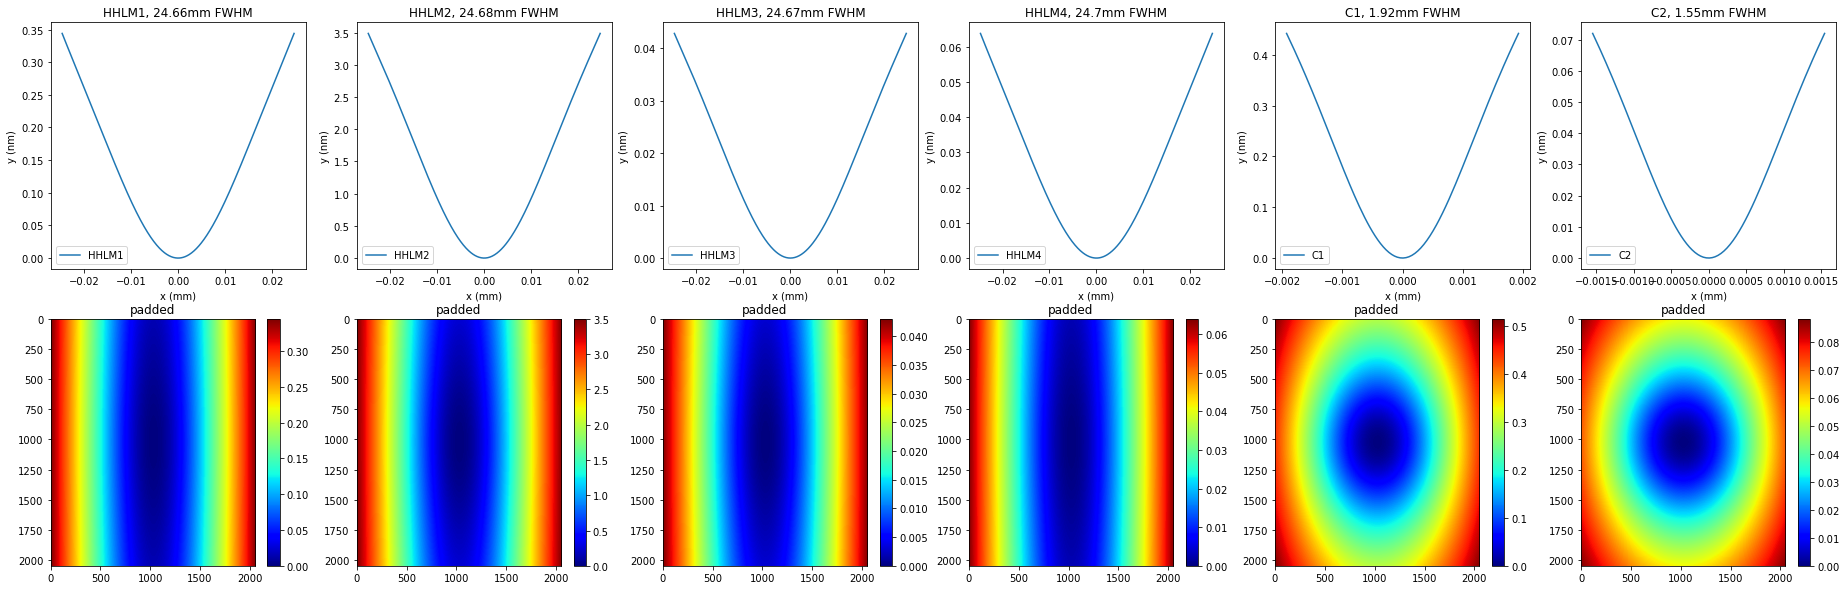

In [7]:
dir_profile = '../DXS_Xtals_FEA4WFS/'
dir_plot = dir_case+'{}_{}_{}/'.format(HHLM_type, hkl1[0]*100+hkl1[1]*10+hkl1[0],
                                      hkl2[0]*100+hkl2[1]*10+hkl2[0]); make_dir(dir_plot)
dir_plot += '{}_{}_deg_{}x_distance/'.format(alphaAsym1, alphaAsym2, HHLM_distance_factor); make_dir(dir_plot)

# holders
shapeErrors = [None for i in range(n_crys)]
x_mirs      = [None for i in range(n_crys)]
y_mirs      = [None for i in range(n_crys)]

crystal_profile_powers = np.array([
    [73.15, 16.53, 0.029, 0.027, 0.026, 0.03],
    [73.15, 16.79, 0.015, 0.015, 0.014, 0.013],
    [4.51, 50.1, 1.78, 1.69, 1.61, 1.88]
])

# choose which profile to use based on intended crystal power
ratio_power = crystal_profile_powers/np.stack([crystal_powers for i in range(3)])

for i in range(3):
    for j in range(n_crys):
        if ratio_power[i,j] <=1:
            ratio_power[i,j] = 1/ratio_power[i,j]

# pick the most similar case to scale up/down for each crystal
options = []
for i in range(n_crys):
    options.append(ratio_power[:,0].argmin()+1)

for i, crystal in enumerate(crystals):
    # load profiles from file
    num = (options[i]-1)*n_crys + i+1
    dy, xx, zz = load_crystal_data(num, dir_profile)
    
    # change height linearly with power
    height_factor1 = crystal_powers[i] / crystal_profile_powers[options[i]-1, i]    
    
    # change height linearly with footprint
    height_factor2 = (l_crystal[i]/(xx.max()-xx.min()))*(w_crystal[i]/(zz.max()-zz.min()))*1e6

    shapeErrors[i] = dy * 1e6 * height_factor1 / height_factor2    # shapeErrors in [nm]
    x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, xx.shape[0])
    y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, xx.shape[1])

# # padding
# for i in range(n_crys):
#     shape = shapeErrors[i]
    
#     # crystal length, width and resolutions; crystals are made to have the same size as the shapeError profiles at the moment
#     l_crystal[i] = (x_mirs[i].max() - x_mirs[i].min())*1e-3; dx = (x_mirs[i][1]-x_mirs[i][0])*1e-3
#     w_crystal[i] = (y_mirs[i].max() - y_mirs[i].min())*1e-3; dy = (y_mirs[i][1]-y_mirs[i][0])*1e-3
    
#     # padded dimension
#     size_x_padded = np.int(l_crystal[i]/dx) + 1; size_x_padded = size_x_padded + size_x_padded%2
#     size_y_padded = np.int(w_crystal[i]/dy) + 1; size_y_padded = size_y_padded + size_y_padded%2

#     # padding the out-skirt with maximum heights
#     shapeError_new = np.ones((size_x_padded, size_y_padded)) * shape.max()
#     roi_x_i = int((size_x_padded - shape.shape[0])/2)
#     roi_x_f = roi_x_i + shape.shape[0]
#     roi_y_i = int((size_y_padded - shape.shape[1])/2)
#     roi_y_f = roi_y_i + shape.shape[1]

#     shapeError_new[roi_x_i:roi_x_f, roi_y_i:roi_y_f] = shape.T
#     shapeErrors[i] = shapeError_new.T

##### plots
plt.figure(figsize=(int(5*n_crys)+2, 10))
for i in range(n_crys):
    plt.subplot(2,n_crys, int(i+1))
    plt.plot(x_mirs[i], shapeErrors[i][1024,:], label=crystals[i])
    plt.legend()
    plt.xlabel('x (mm)')
    plt.ylabel('y (nm)')
    plt.title('{}, {}mm FWHM'.format(crystals[i], round(l_crystal[i]/2*1e3,2)))
    plt.subplot(2,n_crys, n_crys+(int(i+1)))
    
    plt.imshow(shapeErrors[i], cmap='jet')
    plt.colorbar()
    plt.title('padded')
    plt.axis('tight')

plt.savefig(dir_plot+'shapeErrors.png')

### Calculate slit width

In [8]:
%%capture capt
mono_devices, mono_beamline = define_beamline(E0,
                               m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

''' propagate '''
beam_params['photonEnergy'] = E0
b1 = beam.Beam(beam_params=beam_params)
b2 = mono_beamline.propagate_beamline(b1)


In [9]:
def calc_slit_width(inbeam, lmbd, foc):
    # inbeam is the beamsize (2x FWHM) after Crystal 2
    # lmbd is wavelength of photon
    # asym is asymmetry angle of Crystal 2
    # foc is Mir1/Lens1 focal distance
    # returns mono focus size in [m] at the Fourier plane
    slt = 2*np.log(2)*lmbd*foc/np.pi/inbeam
    return 2.11 * slt    # 2x FWHM with some error (~factor of 5%)

wx = mono_beamline.im_after_C2.beam_analysis(mono_beamline.im_after_C2.get_profile_x(), mono_beamline.im_after_C2.get_profile_y())[2]
slit_width = calc_slit_width(wx*2, b2.lambda0, mono_beamline.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6:
    slit_width = 3e-6

print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))


calculated slit width: 0.87um
actual slit width: 3.0um



### M2_p optimization (perfect case)

In [15]:
%%capture capt
n_loop = 31
m2_p = np.linspace(150, 200, n_loop)
pulse_duration = np.zeros_like(m2_p)
pulse_tilt = np.zeros_like(m2_p)
spatial_chirp = np.zeros_like(m2_p)
energy_bandwidth = np.zeros_like(m2_p)

for i in range(n_loop):
    mono_devices, mono_beamline = define_beamline(E0,
                               m1_p=m1_p, m2_p=m2_p[i], HHLM_type=HHLM_type,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=[None for i in range(6)],
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

    screen_names = ['im_input','im_out']
    
    beam_params['photonEnergy'] = E0
    pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
    pulse.propagate(beamline=mono_beamline,screen_names=screen_names)
    c, pulse_duration[i] = pulse.pulse_duration('im_out')
    pulse_tilt[i] = pulse.pulsefront_tilt('im_out')
    spatial_chirp[i] = pulse.spatial_chirp('im_out')
    energy_bandwidth[i] = pulse.pulse_bandwidth('im_out')


KeyboardInterrupt: 

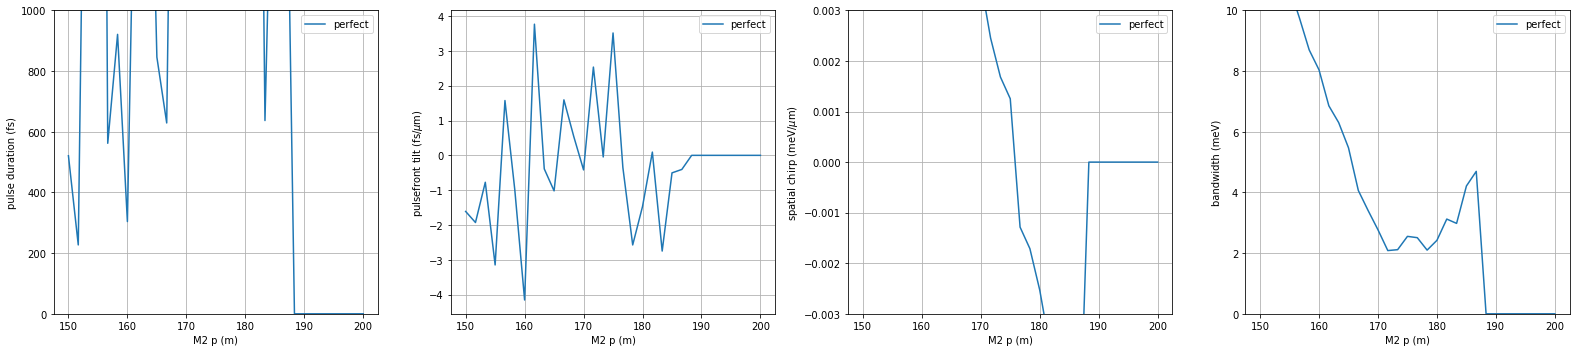

In [16]:
##### plots
plt.figure(figsize=(22,5))
# plt.suptitle('M2_p = {}'.format(result))

plt.subplot(1,4,1)
plt.plot(m2_p, pulse_duration,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel('pulse duration (fs)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([0, 1e3])

plt.subplot(1,4,2)
plt.plot(m2_p, pulse_tilt,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.subplot(1,4,3)
plt.plot(m2_p, spatial_chirp*1000,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([-3e-3, 3e-3])

plt.subplot(1,4,4)
plt.plot(m2_p, energy_bandwidth*1000,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel('bandwidth (meV)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([0, 10])

plt.savefig(dir_plot+'M2_p_optimization.png')

In [17]:
import winsound
winsound.Beep(1500, 3000)